In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [205]:
# 1. 저장된 모델, 임계치, 인코더더 불러오기
# 커스텀 NotEqual 레이어 정의
class CustomNotEqual(Layer):
    def __init__(self, **kwargs):
        super(CustomNotEqual, self).__init__(**kwargs)
    
    # 실제 연산은 call()에서 진행: x와 mask_value를 받아 not_equal 연산 수행
    def call(self, x, mask_value):
        result = tf.math.not_equal(x, mask_value)
        
        if result.shape.ndims == 3:
            result = tf.reduce_all(result, axis=-1)
        return result
    
    # __call__을 오버라이드하여 positional argument로 전달된 mask_value를 keyword로 전환
    def __call__(self, *args, **kwargs):
        # Keras는 입력 텐서 외에 mask_value를 positional argument로 전달하는 경우가 있으므로,
        # 이를 keyword 인자로 변환합니다.
        if len(args) > 1:
            kwargs['mask_value'] = args[1]
            args = args[:1]
        return super(CustomNotEqual, self).__call__(*args, **kwargs)
    
    def get_config(self):
        config = super(CustomNotEqual, self).get_config()
        return config

# 'Any' 객체는 저장된 config에 등장하는 'Any'를 위한 더미 레이어입니다.
class AnyLayer(Layer):
    def __init__(self, **kwargs):
        # config에 'keepdims' 등이 포함되어 있을 수 있으므로 제거
        kwargs.pop('keepdims', None)
        super(AnyLayer, self).__init__(**kwargs)
    
    def call(self, inputs, **kwargs):
        return inputs
    
    def get_config(self):
        config = super(AnyLayer, self).get_config()
        return config

# custom_objects에 등록합니다.
get_custom_objects()['NotEqual'] = CustomNotEqual
get_custom_objects()['Any'] = AnyLayer

loaded_model = load_model('./LSTM_결과/임계치_0.2891_2.h5', custom_objects={'mse': MeanSquaredError(), 'NotEqual': CustomNotEqual, 'Any': AnyLayer})

# 임계치 불러오기
with open('./LSTM_결과/임계치_0.2891_2.pkl', 'rb') as f:
    threshold = pickle.load(f)

# LabelEncoder 불러오기
with open('./LSTM_결과/event_type_encoder2.pkl', 'rb') as f:
    le_event = pickle.load(f)

with open('./LSTM_결과/hub_type_encoder2.pkl', 'rb') as f:
    le_hub = pickle.load(f)

# MinMaxScaler 불러오기
with open('./LSTM_결과/scaler2.pkl', 'rb') as f:
    scaler = pickle.load(f)

# 새로운 Label 처리
def safe_transform(le, values):
    # LabelEncoder에 없는 새로운 값 찾기
    unknown_values = set(values) - set(le.classes_)
    
    # 새로운 값이 있으면 LabelEncoder 클래스에 추가
    if unknown_values:
        print(f"Warning: 새로운 값 발견 {unknown_values}. 새로운 라벨로 추가합니다.")
        le.classes_ = np.append(le.classes_, list(unknown_values))
    else:
        print("새로운 값이 없습니다. 기존 클래스만 변환합니다.")

    return le.transform(values)

print("불러온 임계치:", threshold)

불러온 임계치: 0.2891788410406635


In [206]:
# 2. 테스트 데이터 불러오기  
df_normal_test = pd.read_csv("./Data/실험데이터_정상_100ver01.csv")
df_anomaly_test = pd.read_csv("./Data/실험데이터_이상_31ver01.csv", encoding='cp949')

# 각 데이터에 레이블 추가: 정상 0, 이상 1
df_normal_test['label'] = 0
df_anomaly_test['label'] = 1

# 두 데이터를 합침
df_test = pd.concat([df_normal_test, df_anomaly_test], ignore_index=True)

In [207]:
# 3. 테스트 데이터 전처리  
# (학습 시 사용한 전처리와 동일하게 처리해야 함)
df_test['event_time'] = pd.to_datetime(df_test['event_time'])
df_test = df_test.sort_values(by=['epc_code', 'product_serial', 'event_time'])

# 각 제품 그룹별 첫 이벤트 기준으로 시간 차이(time_delta) 계산
df_test['time_delta'] = df_test.groupby(['epc_code', 'product_serial'])['event_time'] \
                               .transform(lambda x: (x - x.min()).dt.total_seconds())

# 범주형 변수 인코딩
df_test['event_type_enc'] = safe_transform(le_event, df_test['event_type'])
df_test['hub_type_enc'] = safe_transform(le_hub, df_test['hub_type'])

# 수치형 변수 정규화
df_test['time_delta_scaled'] = scaler.transform(df_test[['time_delta']])

In [208]:
print("전처리 후 데이터 샘플:")
display(df_test[['epc_code', 'product_serial', 'event_time', 'time_delta', 
          'event_type', 'event_type_enc', 'hub_type', 'hub_type_enc', 'time_delta_scaled']].head(10))

전처리 후 데이터 샘플:


,epc_code,product_serial,event_time,time_delta,event_type,event_type_enc,hub_type,hub_type_enc,time_delta_scaled
5208,001.6923243.102743.000037501,37501,2025-01-21 17:54:00,0.0,custom_inbound,14,Yeongju,15,0.000000
5209,001.6923243.102743.000037501,37501,2025-01-24 17:21:00,257220.0,stock_inbound(HUB),4,Yeongju,15,0.021394
5210,001.6923243.102743.000037501,37501,2025-01-25 01:23:00,286140.0,custom_outbound,13,Busan_gumjung,1,0.023799
5211,001.6923243.102743.000037501,37501,2025-01-26 18:17:00,433380.0,stock_inbound(HUB),4,Busan_gumjung,1,0.036045
5212,001.6923243.102743.000037501,37501,2025-01-26 20:40:00,441960.0,stock_inbound(Wholesaler),6,Busan_yangsan,2,0.036759
5213,001.6923243.102743.000037501,37501,2025-02-06 23:06:00,1401120.0,stock_outbound(Wholesaler),9,Busan_yangsan,2,0.116535
5214,001.6923243.102743.000037501,37501,2025-02-07 08:24:00,1434600.0,stock_inbound(reseller),10,Busan_dongnea,0,0.119319
5215,001.6923243.102743.000037501,37501,2025-03-15 22:54:00,4597200.0,stock_outbound(sell),11,Busan_dongnea,0,0.382360
5216,001.6923243.102743.000037502,37502,2025-01-21 17:54:00,0.0,custom_inbound,14,Yeongju,15,0.000000
5217,001.6923243.102743.000037502,37502,2025-01-26 22:48:00,449640.0,custom_outbound,13,Seoul_donggu,13,0.037398


In [209]:
# 4. 시퀀스 데이터 구성 함수 (학습 시와 동일)
max_seq_length = 10
feature_columns = ['event_type_enc', 'hub_type_enc', 'time_delta_scaled']

def create_sequence_fixed(group, max_seq_length, feature_columns):
    seq = group[feature_columns].values.astype(np.float32)  # (num_events, num_features)
    if len(seq) < max_seq_length:
        # 부족한 부분은 -1.0으로 패딩 (학습 시와 동일한 값 사용)
        padding = np.full((max_seq_length - len(seq), len(feature_columns)), -1.0, dtype=np.float32)
        seq = np.vstack([seq, padding])
    else:
        # max_seq_length를 초과하면 자르기 앞쪽부터 max_seq_length 길이만 사용
        seq = seq[:max_seq_length]
    return seq

grouped_test = df_test.groupby(['epc_code', 'product_serial'])
# apply를 사용하면 pandas Series 형태로 반환되므로 리스트 comprehension을 사용
sequences_test = [create_sequence_fixed(group, max_seq_length, feature_columns) for _, group in grouped_test]
X_test = np.stack(sequences_test)
print("테스트 시퀀스 데이터 shape:", X_test.shape)  # (그룹 수, max_seq_length, feature 수)

테스트 시퀀스 데이터 shape: (513, 10, 3)


In [210]:
# 5. 테스트 데이터 예측 및 재구성 오차 계산
X_pred_test = loaded_model.predict(X_test)
reconstruction_errors_test = np.mean(np.square(X_pred_test - X_test), axis=(1,2))

# 저장된 임계치(threshold)보다 오차가 큰 시퀀스는 이상으로 판정
predicted_anomalies = reconstruction_errors_test > threshold

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [211]:
# 6. 그룹별 실제 레이블 결정  
# 한 그룹 내에 하나라도 이상 이벤트(label==1)가 있으면 해당 시퀀스를 이상으로 간주합니다.
group_labels = grouped_test['label'].max()  # 그룹별 max 값 (0 또는 1)
group_labels = group_labels.sort_index()  # 시퀀스 데이터 순서와 동일하게 정렬

테스트 데이터 그룹(시퀀스) 총 개수: 513
모델이 이상으로 판정한 그룹 수: 182
이상 탐지된 epc_code 목록: ['001.6923243.102743.000037501' '001.6923243.102743.000037502'
 '001.6923243.102743.000037503' '001.6923243.102743.000037504'
 '001.6923243.102743.000037505' '001.6923243.102743.000037506'
 '001.6923243.102743.000037507' '001.6923243.102743.000037508'
 '001.6923243.102743.000037509' '001.6923243.102743.000037510'
 '001.8805843.238435.000049998' '001.8805843.238435.000049999'
 '001.8805843.238435.000050000' '001.8805843.584374.000000101'
 '001.8805843.584374.000000103' '001.8805843.584374.000000106'
 '001.8805843.584374.000000109' '001.8805843.584374.000000110'
 '001.8805843.584374.000000111' '001.8805843.584374.000000113'
 '001.8805843.584374.000000119' '001.8805843.584374.000000120'
 '001.8805843.584374.000000122' '001.8805843.584374.000000123'
 '001.8805843.584374.000000126' '001.8805843.584374.000000129'
 '001.8805843.584374.000000130' '001.8805843.584374.000000136'
 '001.8805843.584374.000000140' '001.8805843.5843

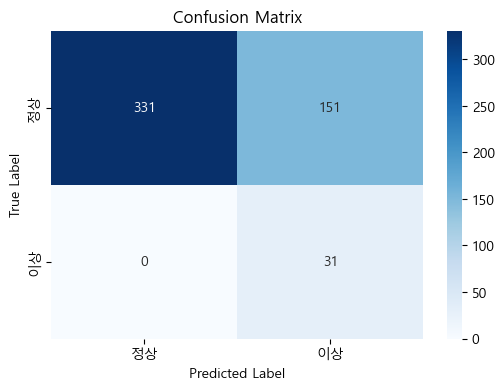

Metrics DataFrame:
     precision(정밀도)  recall(재현율)  f1-score(점수)
정상         1.00000     0.686722      0.814268
이상         0.17033     1.000000      0.291080


In [212]:
# 7. 결과 평가
num_sequences = len(X_test)
num_detected = predicted_anomalies.sum()

print(f"테스트 데이터 그룹(시퀀스) 총 개수: {num_sequences}")
print(f"모델이 이상으로 판정한 그룹 수: {num_detected}")

epc_codes = grouped_test['epc_code'].first().sort_index()
anomalous_epc_codes = epc_codes[predicted_anomalies]
print("이상 탐지된 epc_code 목록:", anomalous_epc_codes.values)

# 혼동 행렬 및 분류 리포트 출력 및 시각화화
cm = confusion_matrix(group_labels, predicted_anomalies)

labels = ["정상", "이상"]

# 한글 폰트 경로 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

print("Confusion Matrix:\n")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 2. 분류 리포트 출력
report_dict = classification_report(group_labels, predicted_anomalies, target_names=["정상", "이상"], output_dict=True)

# pandas DataFrame으로 변환
report_df = pd.DataFrame(report_dict).transpose()

metrics_df = report_df.loc[['정상', '이상']][['precision', 'recall', 'f1-score']]

metrics_df.columns = ['precision(정밀도)', 'recall(재현율)', 'f1-score(점수)']
print("Metrics DataFrame:\n", metrics_df)